In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')
game.reward()

-1

In [4]:
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [5]:
import numpy as np
import torch
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt
from IPython.display import clear_output


In [6]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4
 
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
gamma = 0.9
epsilon = 1.0


In [7]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [8]:
epochs = 1000
losses = []

#add noise to the state to help with over fitting, and no "dead neurons" for the ReLu since it is
#non-differentiable at 0
noise = np.random.rand(1,64)/10.0

for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    
    #take the 4x4x4 board and make it a 1X64 vector seems like it adds some noise
    state_ = game.board.render_np().reshape(1,64) + noise #D
    state1 = torch.from_numpy(state_).float()
    status = 1
    while (status == 1):
        
        #feed the current state into the model
        qval = model(state1)
        
        # change the result of a model pass into a numpy array
        qval_ = qval.data.numpy() 
        
        #pick a random direction if the random number is less then epsilon
        # but we'll mostly pick the position in the action array that has the 
        # highest value
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        #set the current action
        action = action_set[action_]
        
        #do the action that was set
        game.makeMove(action)
        
        #get another state and add some noise, then change it to a tensor
        state2_ = game.board.render_np().reshape(1, 64) + noise
        state2 = torch.from_numpy(state2_).float()
        
        
        reward = game.reward()
        
        #disable gradient calculation , no computational graph becauuse we don't care about state 2 doing
        #back prop only state 1
        with torch.no_grad():
            # send the next state to the model
            newQ = model(state2.reshape(1, 64))
            
        # the max value int the tensor array aka maximum Q value predicted at this state
        maxQ = torch.max(newQ)
        
        #calculates the target Q value 
        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        
        
        #use the .detach to avoid the copy, book says this is unnecessary because
        #we already removed maxQ's computational graph
        Y = torch.Tensor([Y]).detach()
                
        #Set the tensor array to match the current value
        X = qval.squeeze()[action_]
        
        #find the mse of the X and Y
        loss = loss_fn(X, Y)
        
        #zero out the gradient before back prop so pytorch doesn't accumulate the gradient on subsequent 
        #back passes
        #https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()
        
        #print the losses at each epoch, clear_output to only see the last loss per loop
        print(i, loss.item())
        clear_output(wait=True)

        #https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step

      
        #  loss.backward() sets the grad attribute of all tensors with requires_grad=True in the 
        #computational graph of which loss is the leaf (only x in this case).
        loss.backward()
        
        #track the losses for plotting later
        losses.append(loss.item())
        
        
        #Optimizer just iterates through the list of parameters (tensors) it 
        #received on initialization and everywhere where a tensor has 
        #requires_grad=True, it subtracts the value of its gradient stored in its .grad property 
        optimizer.step()
        state1 = state2
        
        #keep the while loop going until the game is won
        if reward != -1:
            status = 0
            
    #reduce epsilon at every epoch
    if epsilon > 0.1:
        epsilon -= (1/epochs)

999 0.04661175608634949


In [36]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50           

In [39]:
for epoch in range(epochs):
    #print("epoch = ", epoch)
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1):
        mov += 1
        
        #feed the current state into the model
        qval = model(state1)
        
        # change the result of a model pass into a numpy array
        qval_ = qval.data.numpy()
        
        #pick a random direction if the random number is less then epsilon
        # but we'll mostly pick the position in the action array that has the 
        # highest value
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        #set the current action
        action = action_set[action_]
        
        #do the action that was set
        game.makeMove(action)
        
        #get another state and add some noise, then change it to a tensor
        state2_ = state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        
        reward = game.reward()
        
        done = True if reward > 0 else False
        
        #store the experience in a tuple (s0, a0, r1, s1)
        exp =  (state1, action_, reward, state2, done)     
        
        #append experience to the replay buffer deque
        replay.append(exp) 
        
        state1 = state2
        
        #if the replay list is at least as large as the minibatch size, begins the mini-batch training
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
            #Recomputes Q values for minibatch of states to get gradient
            Q1 = model(state1_batch)  
        
            #Recomputes Q values for next states, but doesn't computer gradient
            with torch.no_grad():                
                Q2 = model(state2_batch) 
                
            # (1 - done_batch) sets the right side as 0 if the game is over
            # torch.max(Q2, dim=1) returns an a list of softmax of each Q2, for each sample
            # and a list of the index where it was found, this is why you do [0], to get the list of row maxes
            # and drop the indicies for each sample
            # ends up being a (1 X batch_size) + (1 X batch_size) vector addition
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])  
            
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
 
        if reward != -1 or mov > max_moves:   
            status = 0
            mov = 0
losses = np.array(losses)      
        

            
            
        

In [40]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

Text(0, 0.5, 'Loss')

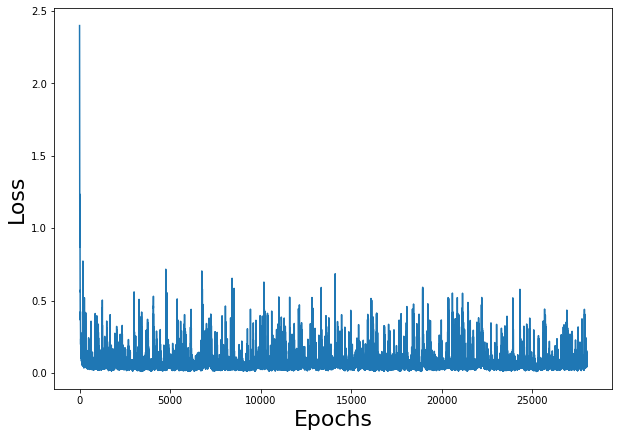

In [41]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)    

In [43]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 910
Win percentage: 91.0%
